# Prediction of anesthetic concentration from EEG
In this example, we will build a model to predict anesthetic concentration (age-related MAC) from EEG during Sevoflurane anesthesia.

> Note that <b>all users who use Vital DB, an open biosignal dataset, must agree to the Data Use Agreement below.
</b> If you do not agree, please close this window.
Click here: [Data Use Agreement](https://vitaldb.net/dataset/?query=overview&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.vcpgs1yemdb5)

[<font color = 'coral'>References Code</font>](https://github.com/vitaldb/examples/blob/master/eeg_mac.ipynb)

## Required libraries

In [1]:
!pip install vitaldb
import vitaldb
import random
import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

  Obtaining dependency information for vitaldb from https://files.pythonhosted.org/packages/aa/f0/7a7f413cbf34bddaa04fc0e7f7dcd14697e04844e33be19657f551a61d07/vitaldb-1.4.5-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 5.8 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
SRATE = 128  # in hz
SEGLEN = 4 * SRATE  # segment samples
MAX_CASES = 100

df_trks = pd.read_csv("https://api.vitaldb.net/trks")  # track information
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # patient information

# track names and column order when loading data
track_names = ['BIS/EEG1_WAV', 'Primus/EXP_DES', 'BIS/BIS']
EEG = 0
DES = 1
BIS = 2

# Inclusion & Exclusion criteria
caseids = set(df_cases.loc[df_cases['age'] > 18, 'caseid'])
caseids &= set(df_trks.loc[df_trks['tname'] == 'BIS/EEG1_WAV', 'caseid'])
caseids &= set(df_trks.loc[df_trks['tname'] == 'BIS/BIS', 'caseid'])
caseids &= set(df_trks.loc[df_trks['tname'] == 'Primus/EXP_SEVO', 'caseid'])
caseids -= set(df_trks.loc[df_trks['tname'] == 'Primus/EXP_DES', 'caseid'])
caseids -= set(df_trks.loc[df_trks['tname'] == 'Orchestra/PPF20_CE', 'caseid'])
caseids -= set(df_trks.loc[df_trks['tname'] == 'Orchestra/RFTN50_CE', 'caseid'])
caseids = list(caseids)
print(f'Total {len(caseids)} cases found')



for i in caseids:
    track_names = ['BIS/EEG1_WAV', 'Primus/EXP_DES', 'BIS/BIS']

    vals = vitaldb.load_case(i, track_names, 1 / SRATE)
    print("Case ID: ",i,":::",np.where(vals[:, DES] > 0.1))

Total 1518 cases found
Case ID:  2 ::: (array([], dtype=int64),)
Case ID:  4 ::: (array([], dtype=int64),)
Case ID:  10 ::: (array([], dtype=int64),)
Case ID:  12 ::: (array([], dtype=int64),)
Case ID:  18 ::: (array([], dtype=int64),)
Case ID:  21 ::: (array([], dtype=int64),)
Case ID:  24 ::: (array([], dtype=int64),)
Case ID:  25 ::: (array([], dtype=int64),)
Case ID:  27 ::: (array([], dtype=int64),)
Case ID:  33 ::: (array([], dtype=int64),)
Case ID:  43 ::: (array([], dtype=int64),)
Case ID:  49 ::: (array([], dtype=int64),)
Case ID:  56 ::: (array([], dtype=int64),)
Case ID:  58 ::: (array([], dtype=int64),)
Case ID:  61 ::: (array([], dtype=int64),)
Case ID:  62 ::: (array([], dtype=int64),)
Case ID:  64 ::: (array([], dtype=int64),)
Case ID:  65 ::: (array([], dtype=int64),)
Case ID:  66 ::: (array([], dtype=int64),)
Case ID:  76 ::: (array([], dtype=int64),)
Case ID:  80 ::: (array([], dtype=int64),)
Case ID:  82 ::: (array([], dtype=int64),)
Case ID:  84 ::: (array([], dtype

## Preprocessing

In [12]:
SRATE = 128  # in hz
SEGLEN = 4 * SRATE  # segment samples
MAX_CASES = 100

df_trks = pd.read_csv("https://api.vitaldb.net/trks")  # track information
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # patient information

# track names and column order when loading data
track_names = ['BIS/EEG1_WAV', 'Primus/EXP_DES', 'BIS/BIS']
EEG = 0
DES = 1
BIS = 2

# Inclusion & Exclusion criteria
caseids = set(df_cases.loc[df_cases['age'] > 18, 'caseid'])
caseids &= set(df_trks.loc[df_trks['tname'] == 'BIS/EEG1_WAV', 'caseid'])
caseids &= set(df_trks.loc[df_trks['tname'] == 'BIS/BIS', 'caseid'])
caseids &= set(df_trks.loc[df_trks['tname'] == 'Primus/EXP_SEVO', 'caseid'])
caseids -= set(df_trks.loc[df_trks['tname'] == 'Primus/EXP_DES', 'caseid'])
caseids -= set(df_trks.loc[df_trks['tname'] == 'Orchestra/PPF20_CE', 'caseid'])
caseids -= set(df_trks.loc[df_trks['tname'] == 'Orchestra/RFTN50_CE', 'caseid'])
caseids = list(caseids)
print(f'Total {len(caseids)} cases found')
#random.shuffle(caseids)

x = []  # eeg
y = []  # DES
b = []  # bis
c = []  # caseids
icase = 0  # number of loaded cases
for caseid in caseids:
    print(f'loading caseid={caseid} ({icase + 1}/{MAX_CASES})', end='...', flush=True)

    # extract data
    vals = vitaldb.load_case(caseid, track_names, 1 / SRATE)
    if np.nanmax(vals[:, DES]) < 1:
        print('all DES < 1%')
        continue

    # convert et DES to the age related mac
    age = df_cases.loc[df_cases['caseid'] == caseid, 'age'].values[0]
    vals[:, DES] /= 1.80 * 10 ** (-0.00269 * (age - 40))

    # exclude cases without bis
    if not np.any(vals[:, BIS] > 0):
        print('all bis <= 0')
        continue

    # exclude cases with use of DES shorter than 30 min
    valid_idx = np.where(vals[:, DES] > 0.1)[0]
    first_idx = valid_idx[0]
    last_idx = valid_idx[-1]
    if last_idx - first_idx < 1800 * SRATE:
        print('len DES < 30 min')
        continue
    vals[:first_idx, DES] = 0

    # trim cases with BIS
    valid_idx = np.where(vals[:, BIS] > 0)[0]
    first_idx = valid_idx[0]
    last_idx = valid_idx[-1]
    vals = vals[first_idx:last_idx + 1, :]

    # exclude cases shorter than 30 min
    if len(vals) < 1800 * SRATE:
        print('len bis < 30 min')
        continue

    # forward fill in MAC value and BIS value up to 7 sec
    vals[:, DES:] = pd.DataFrame(vals[:, DES:]).ffill(limit=7*SRATE).values

    # extract segments
    oldlen = len(y)
    for isamp in range(SEGLEN, len(vals), 2 * SRATE):
        bis = vals[isamp, BIS]
        mac = vals[isamp, DES]
        if np.isnan(bis) or np.isnan(mac) or bis == 0:
            continue
        # add to dataset
        eeg = vals[isamp - SEGLEN:isamp, EEG]
        x.append(eeg)
        y.append(mac)
        b.append(bis)
        c.append(caseid)

    # print results
    icase += 1
    print(f'{len(y) - oldlen} segments read -> total {len(y)} segments ({icase}/{MAX_CASES})')
    if icase >= MAX_CASES:
        break

# Change the input dataset to a numpy array
x = np.array(x)
y = np.array(y)
b = np.array(b)
c = np.array(c)

Total 1518 cases found
loading caseid=2 (1/100)...

/tmp/ipykernel_42/2234941258.py:36: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(vals[:, DES]) < 1:


IndexError: index 0 is out of bounds for axis 0 with size 0

## Filtering input data

In [ ]:
# exclude segments
print('invalid samples...', end='', flush=True)
valid_mask = ~(np.max(np.isnan(x), axis=1) > 0) # if there is nan
valid_mask &= (np.nanmax(x, axis=1) - np.nanmin(x, axis=1) > 12)  # bis impedence check
valid_mask &= (np.nanmax(np.abs(x), axis=1) < 100)  # noisy sample
x = x[valid_mask]
y = y[valid_mask]
b = b[valid_mask]
c = c[valid_mask]
print(f'{100*(1-np.mean(valid_mask)):.1f}% removed')

invalid samples...

<ipython-input-3-03c63be541e1>:4: RuntimeWarning: All-NaN slice encountered

  valid_mask &= (np.nanmax(x, axis=1) - np.nanmin(x, axis=1) > 12)  # bis impedence check

<ipython-input-3-03c63be541e1>:5: RuntimeWarning: All-NaN slice encountered

  valid_mask &= (np.nanmax(np.abs(x), axis=1) < 100)  # noisy sample


12.7% removed


## Splitting samples into training and testing dataset

In [4]:
# caseid
caseids = list(np.unique(c))
#random.shuffle(caseids)

# Split dataset into training and testing data
ntest = max(1, int(len(caseids) * 0.2))
caseids_train = caseids[ntest:]
caseids_test = caseids[:ntest]

train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)
x_train = x[train_mask]
y_train = y[train_mask]
x_test = x[test_mask]
y_test = y[test_mask]
b_test = b[test_mask]
c_test = c[test_mask]

print('====================================================')
print(f'total: {len(caseids)} cases {len(y)} samples')
print(f'train: {len(np.unique(c[train_mask]))} cases {len(y_train)} samples')
print(f'test {len(np.unique(c_test))} cases {len(y_test)} samples')
print('====================================================')

total: 100 cases 568517 samples
train: 80 cases 441068 samples
test 20 cases 127449 samples


## Modeling and Evaluation

In [5]:
import keras.models
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Input, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

out = inp = Input(shape=(x_train.shape[1], 1))
for i in range(4):
    out = Conv1D(filters=32, kernel_size=7, padding='same')(out)
    out = Activation('relu')(out)
    out = MaxPooling1D(2, padding='same')(out)
out = GlobalMaxPooling1D()(out)
out = Dense(128)(out)
out = Dropout(0.2)(out)
out = Dense(1)(out)

model = Model(inputs=[inp], outputs=[out])
model.summary()
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
# fit model. the last 20% of the segments will be used for early stopping
hist = model.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=4096,
                callbacks=[ModelCheckpoint(monitor='val_loss', filepath='model.x', verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')])

# prediction
pred_test = model.predict(x_test).flatten()
for caseid in np.unique(c_test):
    case_mask = (c_test == caseid)
    pred_test[case_mask] = scipy.signal.medfilt(pred_test[case_mask], 15)

# calculate the performance
test_mae = np.mean(np.abs(y_test - pred_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 512, 32)           256       
                                                                 
 activation (Activation)     (None, 512, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 256, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 256, 32)           7200      
                                                                 
 activation_1 (Activation)   (None, 256, 32)           0         
                                                             

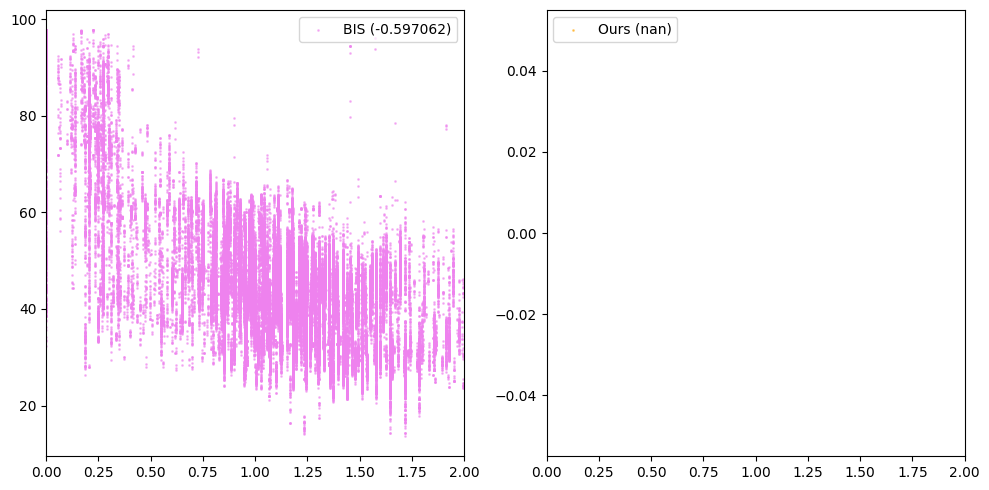

In [6]:
# pearson correlation coefficient
bis_corr = np.corrcoef(y_test, b_test)[0, 1]
our_corr = np.corrcoef(y_test, pred_test)[0, 1]

# scatter plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, b_test, s=1, alpha=0.5, c='violet', label=f'BIS ({bis_corr:4f})')
plt.xlim([0, 2])
plt.legend(loc="upper right")
plt.subplot(1, 2, 2)
plt.scatter(y_test, pred_test, s=1, alpha=0.5, c='orange', label=f'Ours ({our_corr:.4f})')
plt.xlim([0, 2])
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

Total MAE=nan, CaseID 2, MAE=nan


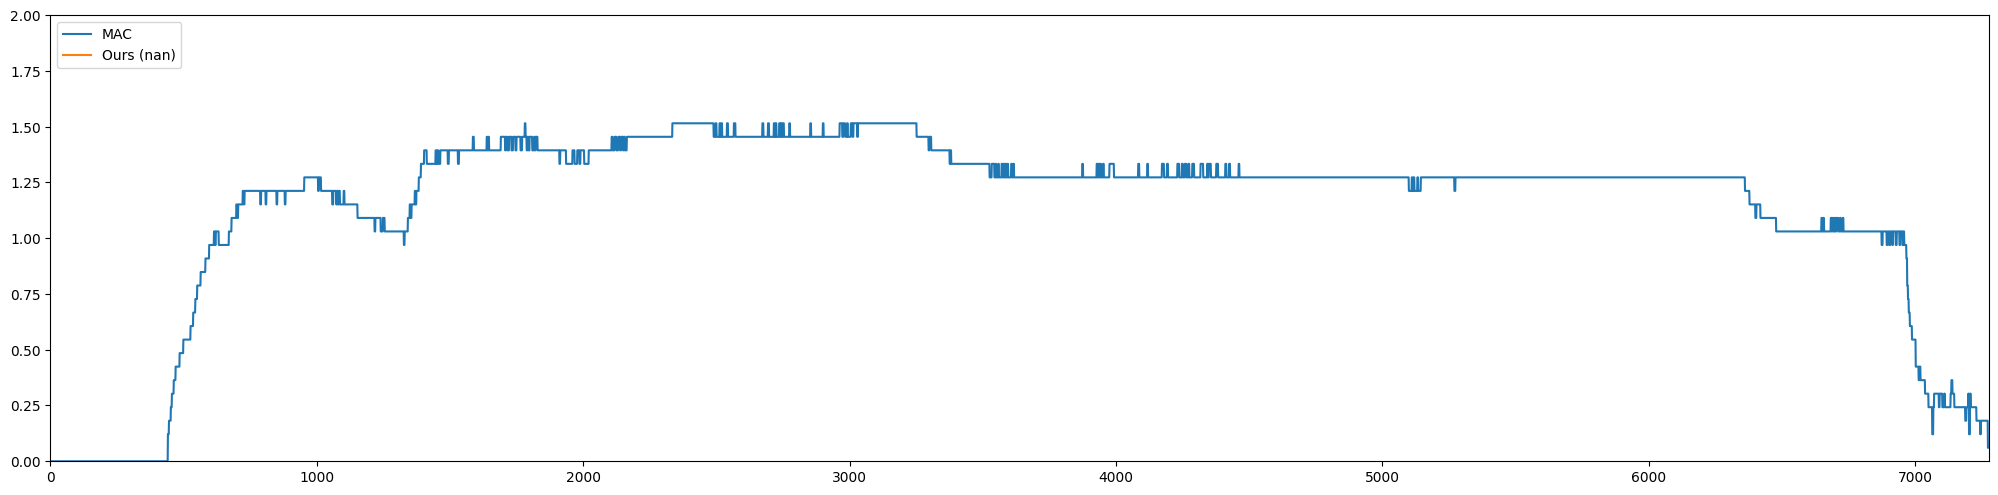

Total MAE=nan, CaseID 4, MAE=nan


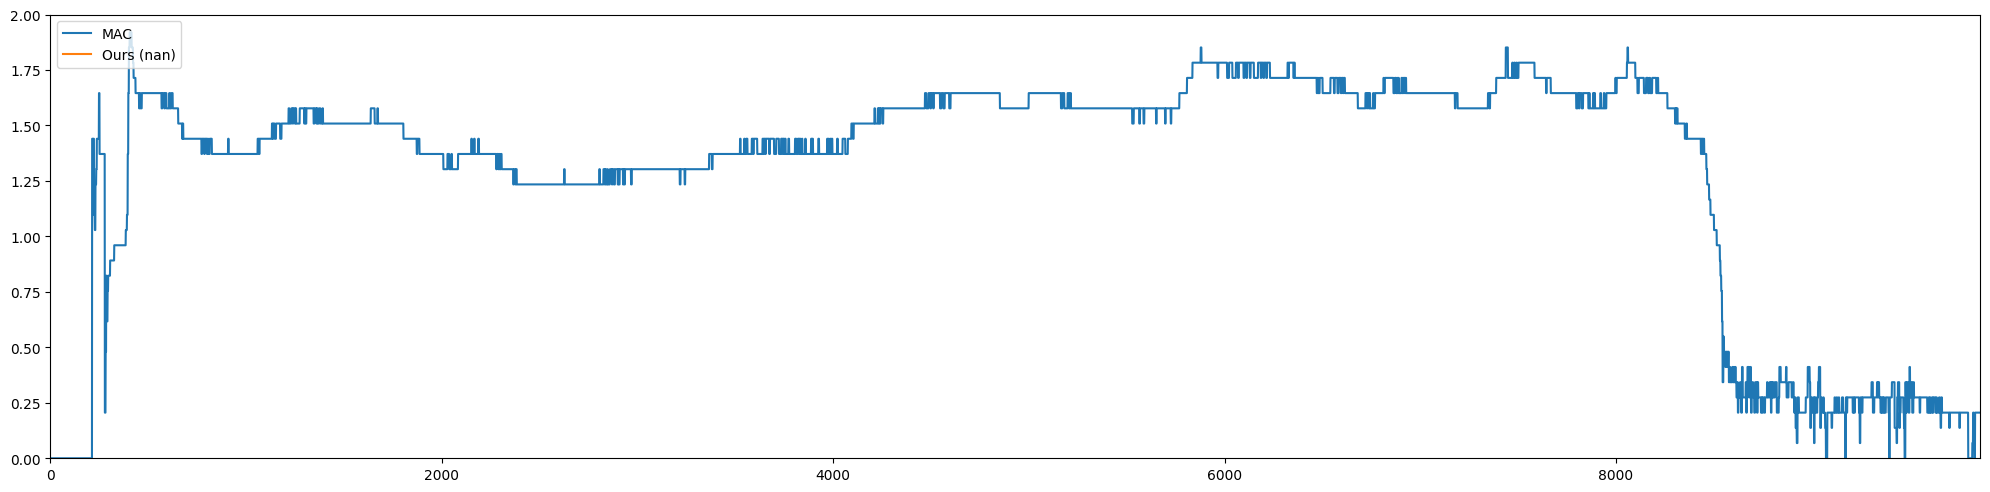

Total MAE=nan, CaseID 10, MAE=nan


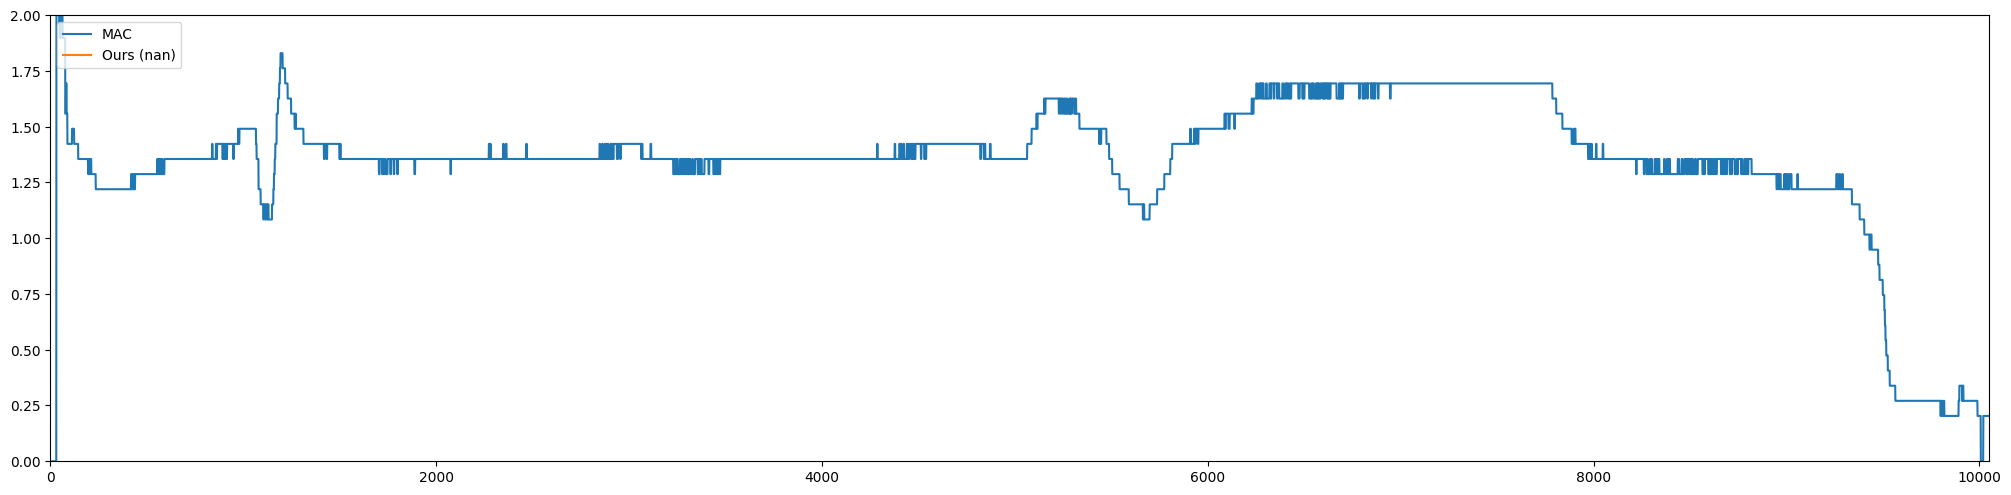

Total MAE=nan, CaseID 12, MAE=nan


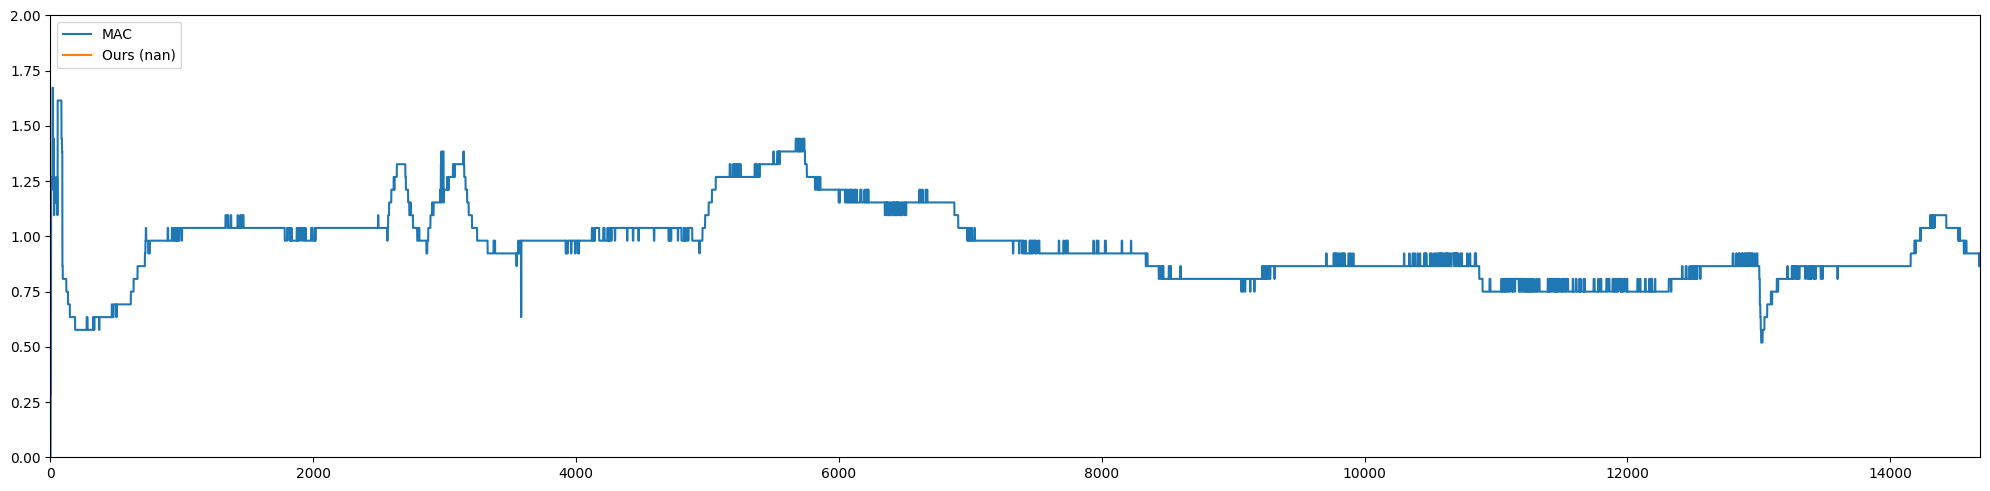

Total MAE=nan, CaseID 21, MAE=nan


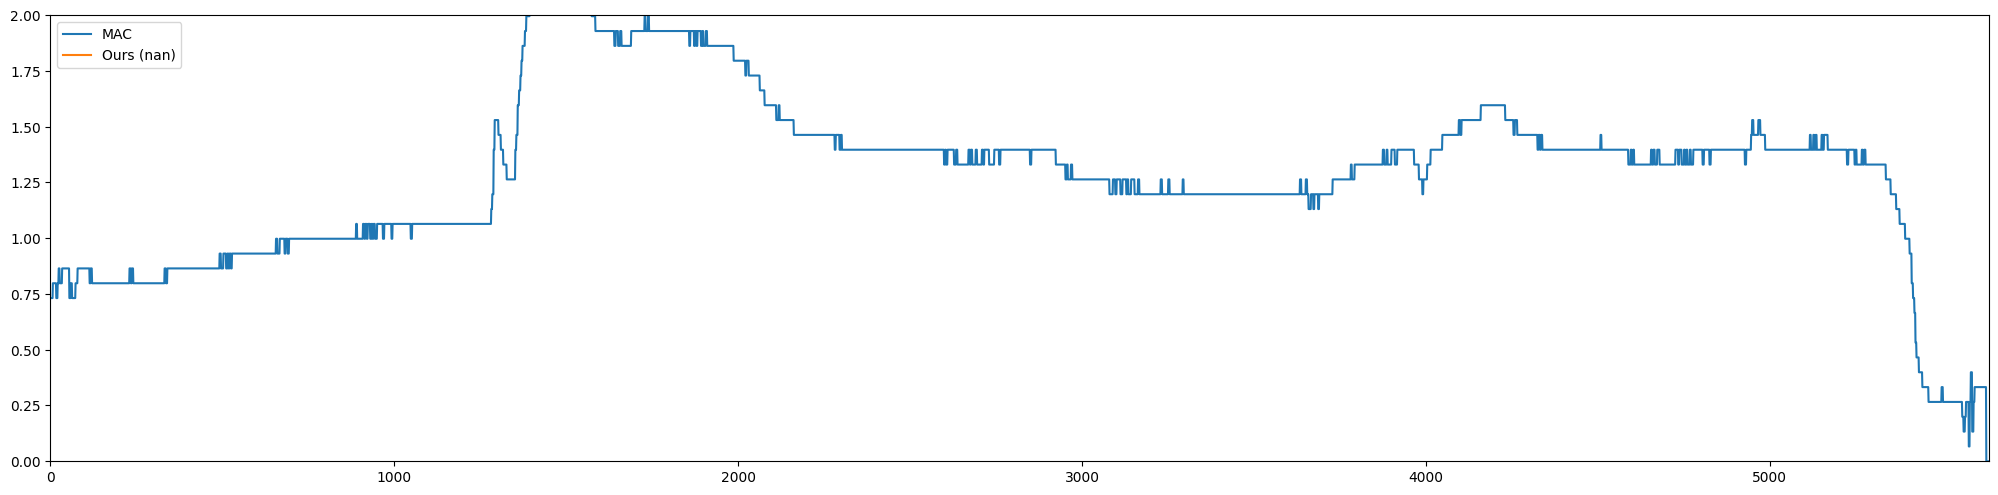

Total MAE=nan, CaseID 24, MAE=nan


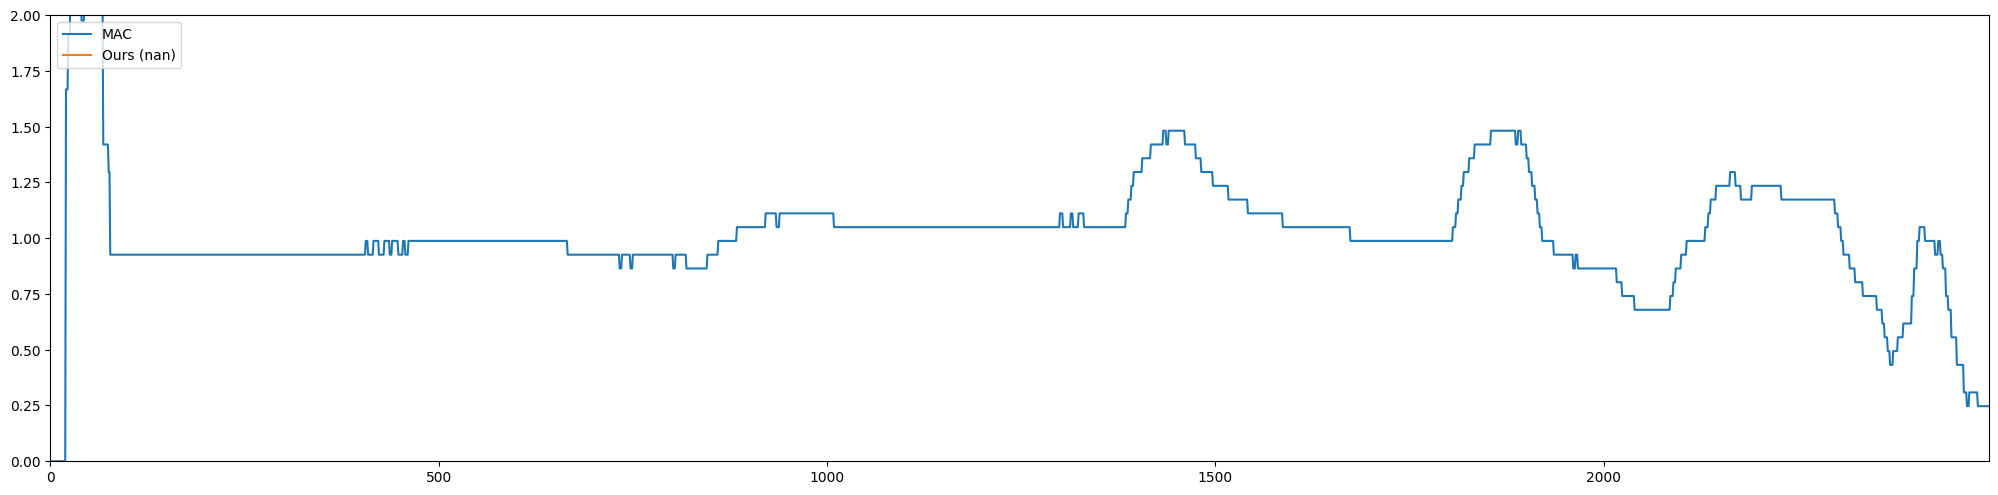

Total MAE=nan, CaseID 25, MAE=nan


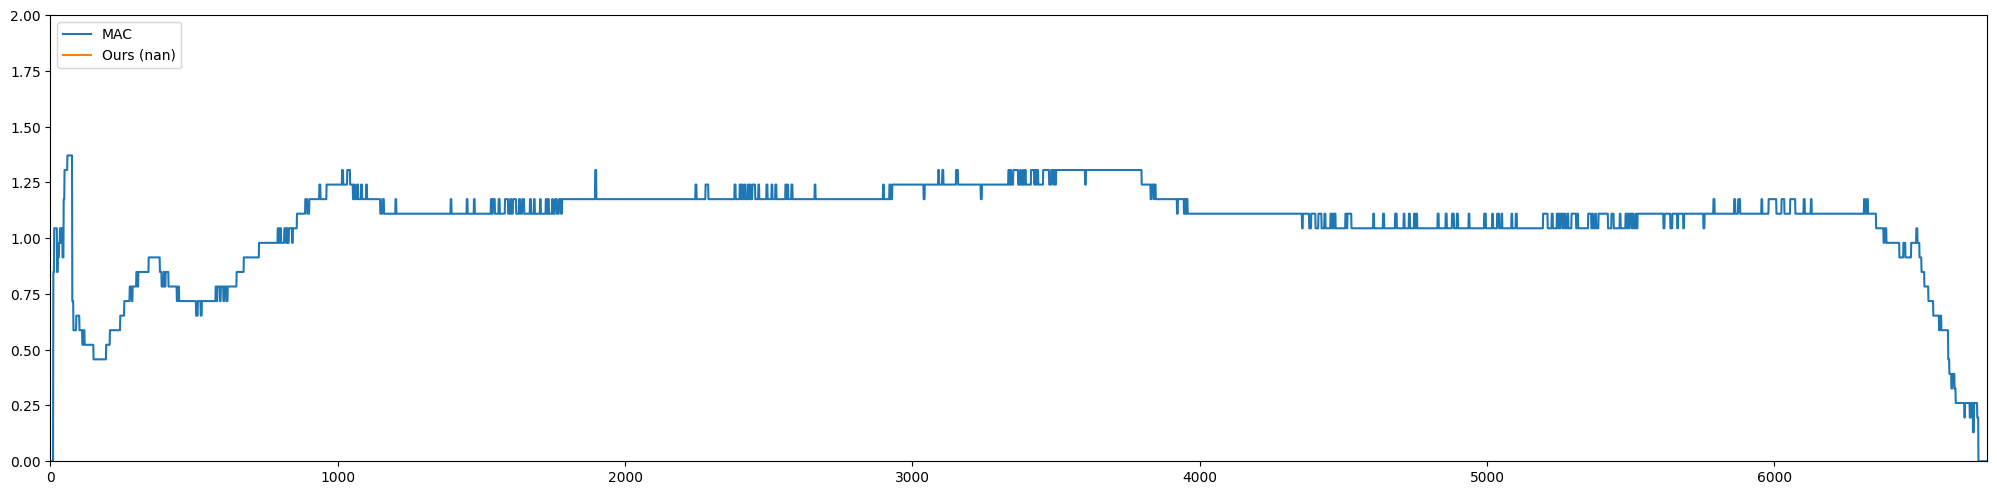

Total MAE=nan, CaseID 27, MAE=nan


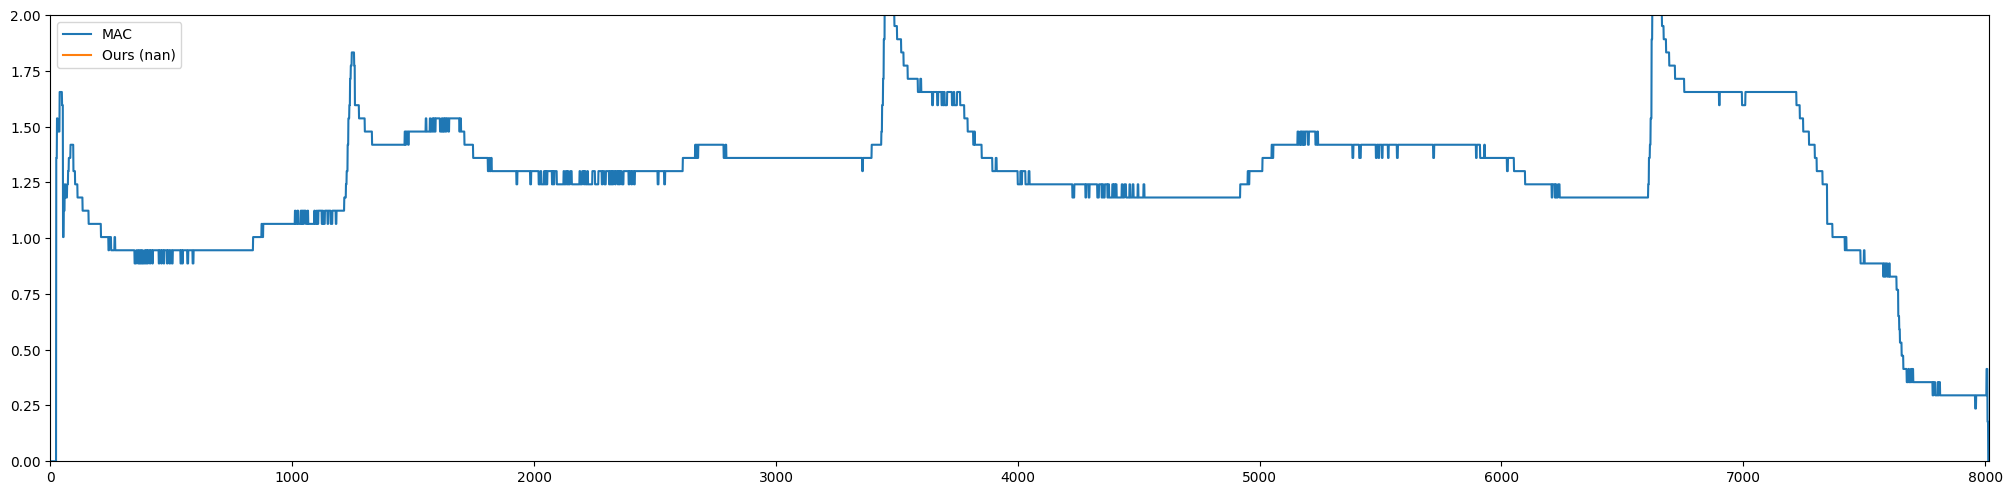

Total MAE=nan, CaseID 33, MAE=nan


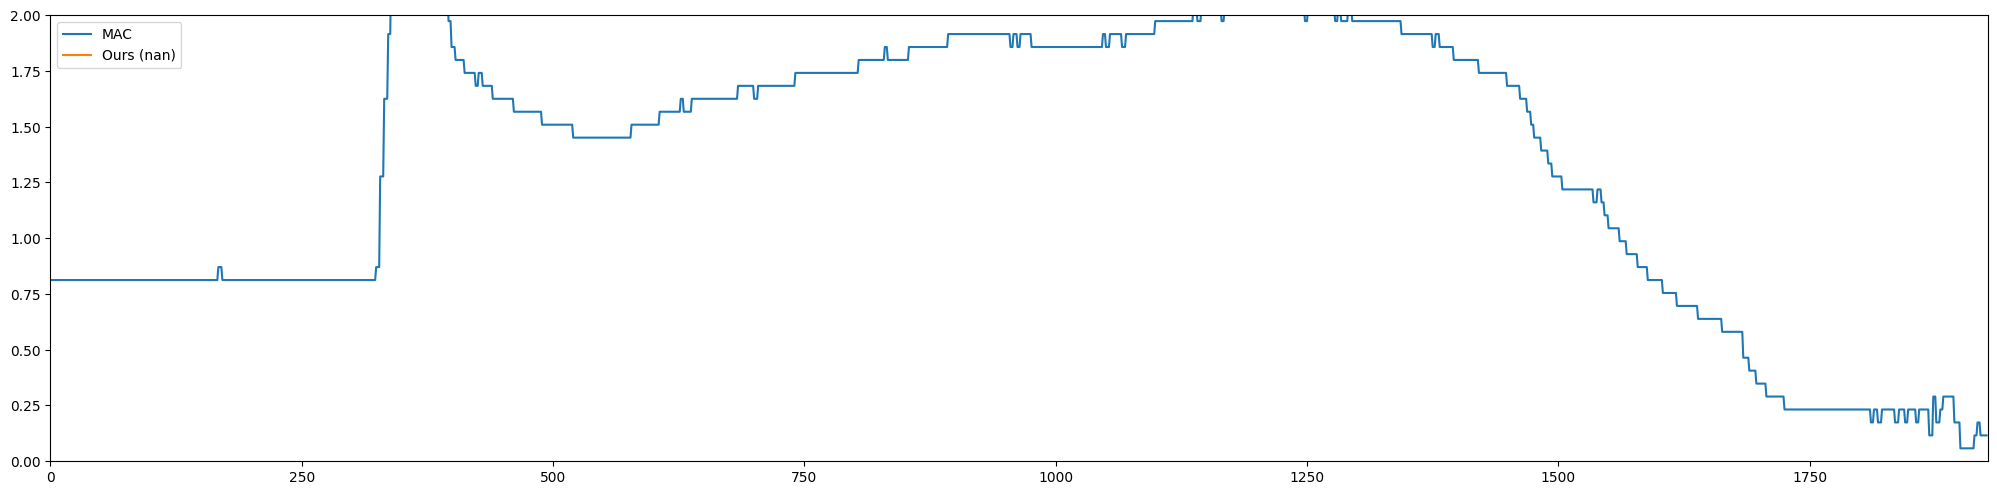

Total MAE=nan, CaseID 43, MAE=nan


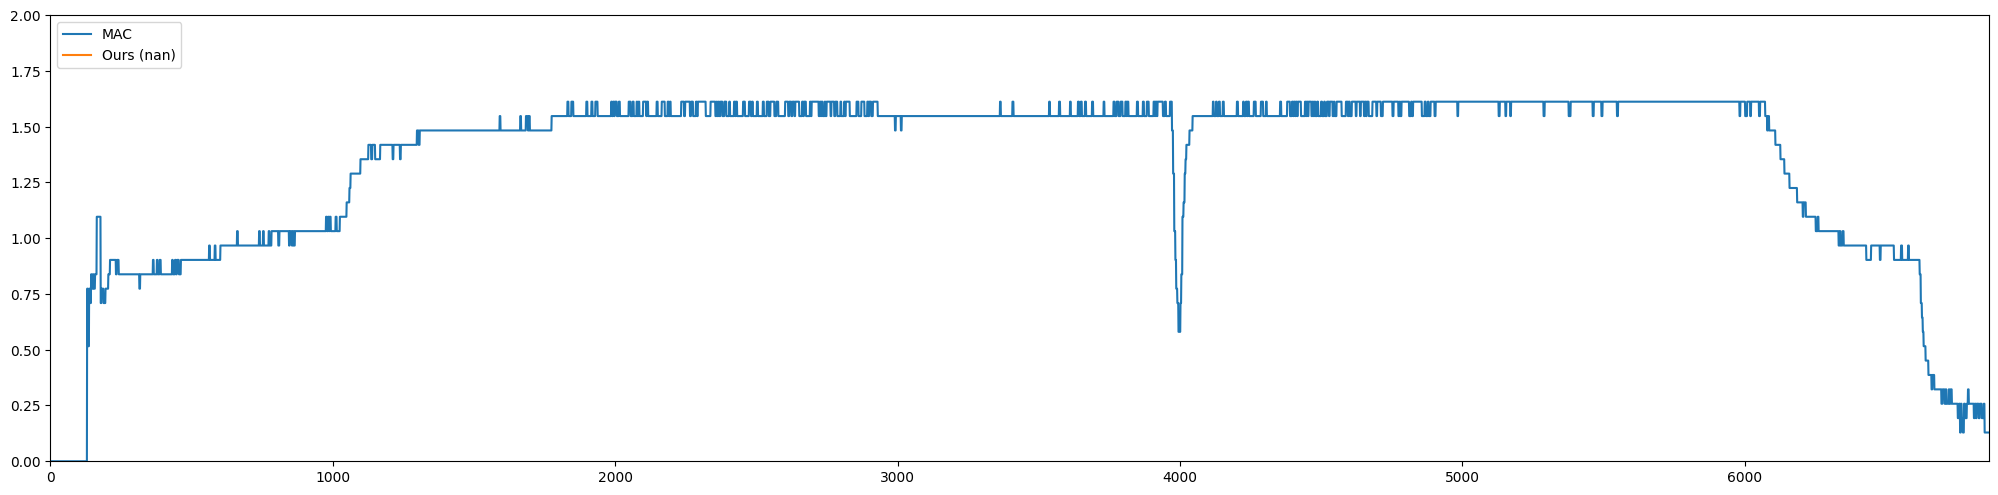

Total MAE=nan, CaseID 56, MAE=nan


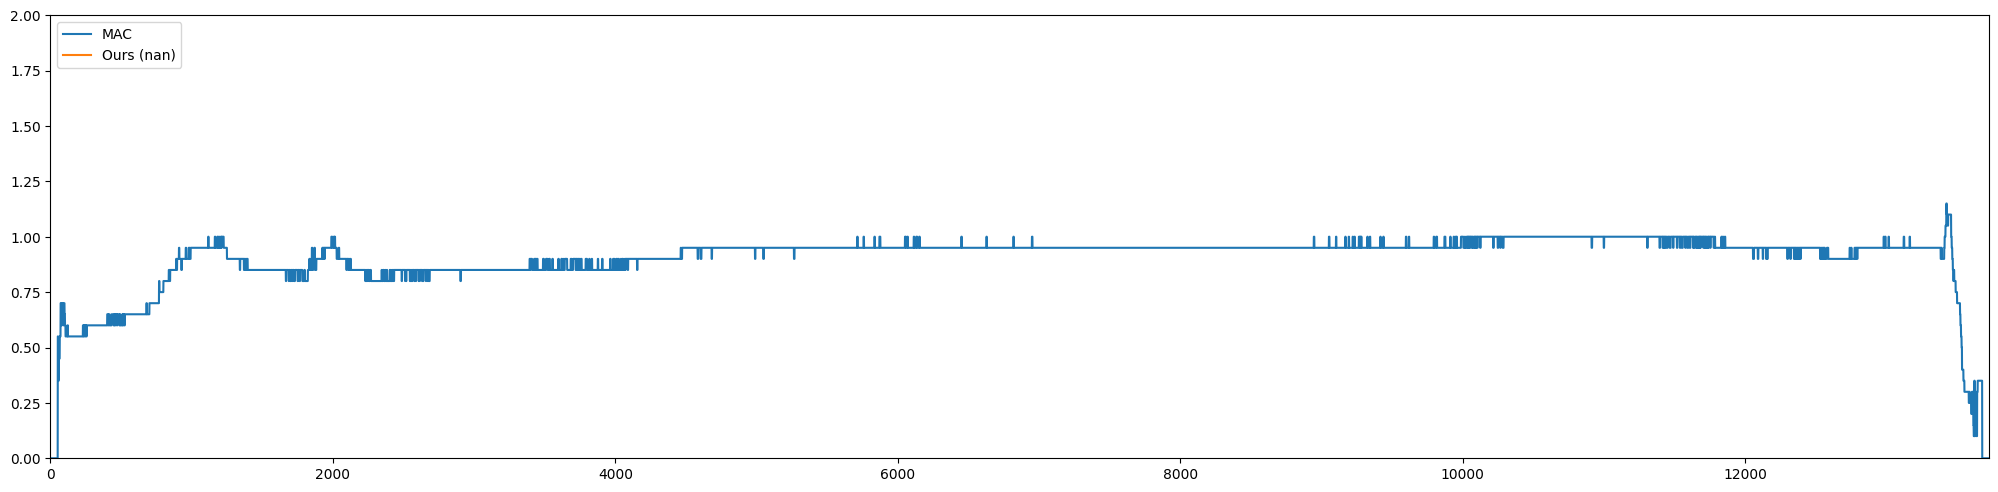

Total MAE=nan, CaseID 58, MAE=nan


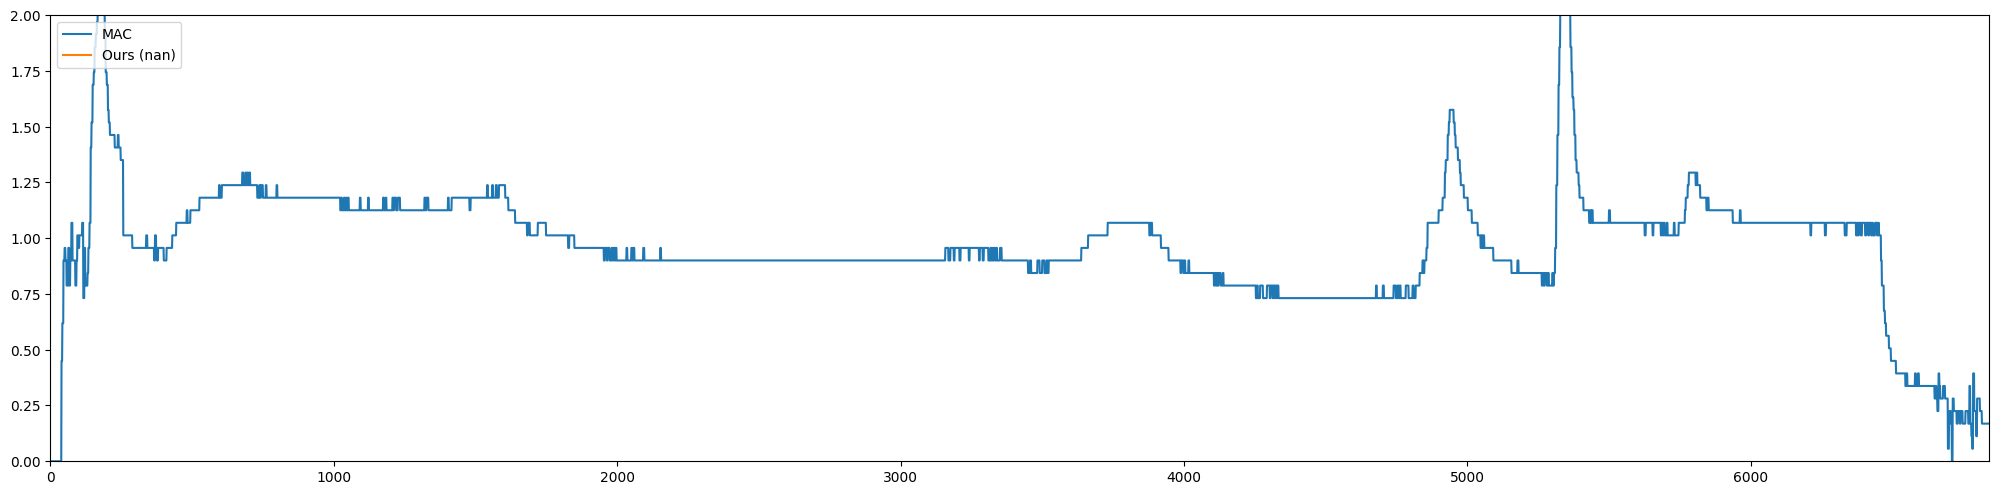

Total MAE=nan, CaseID 61, MAE=nan


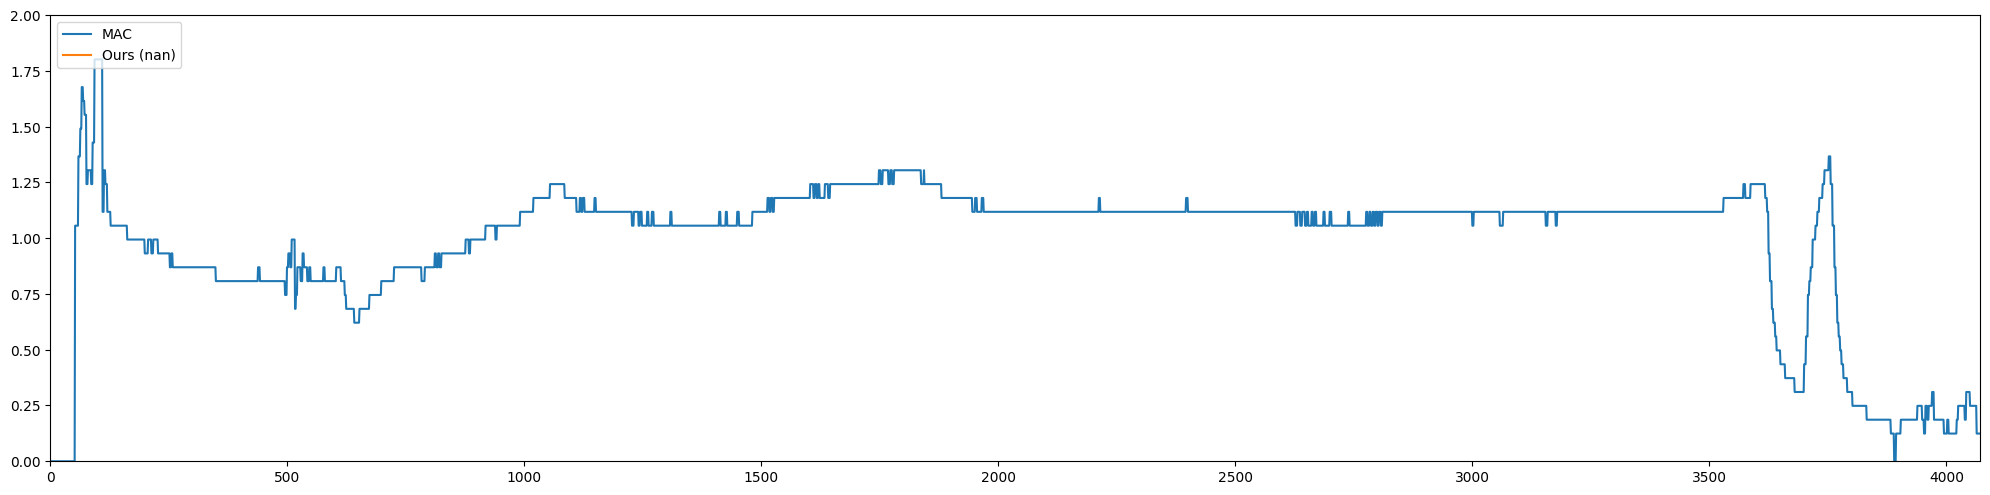

Total MAE=nan, CaseID 62, MAE=nan


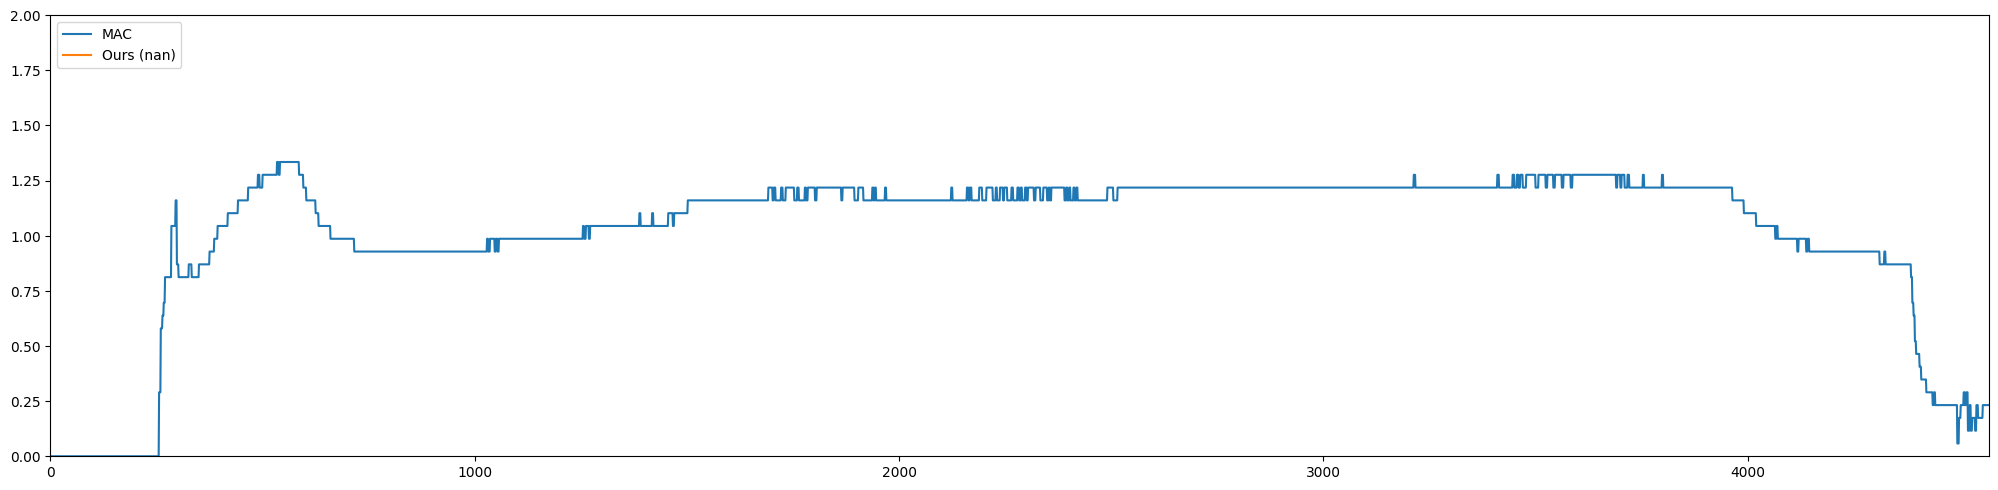

Total MAE=nan, CaseID 64, MAE=nan


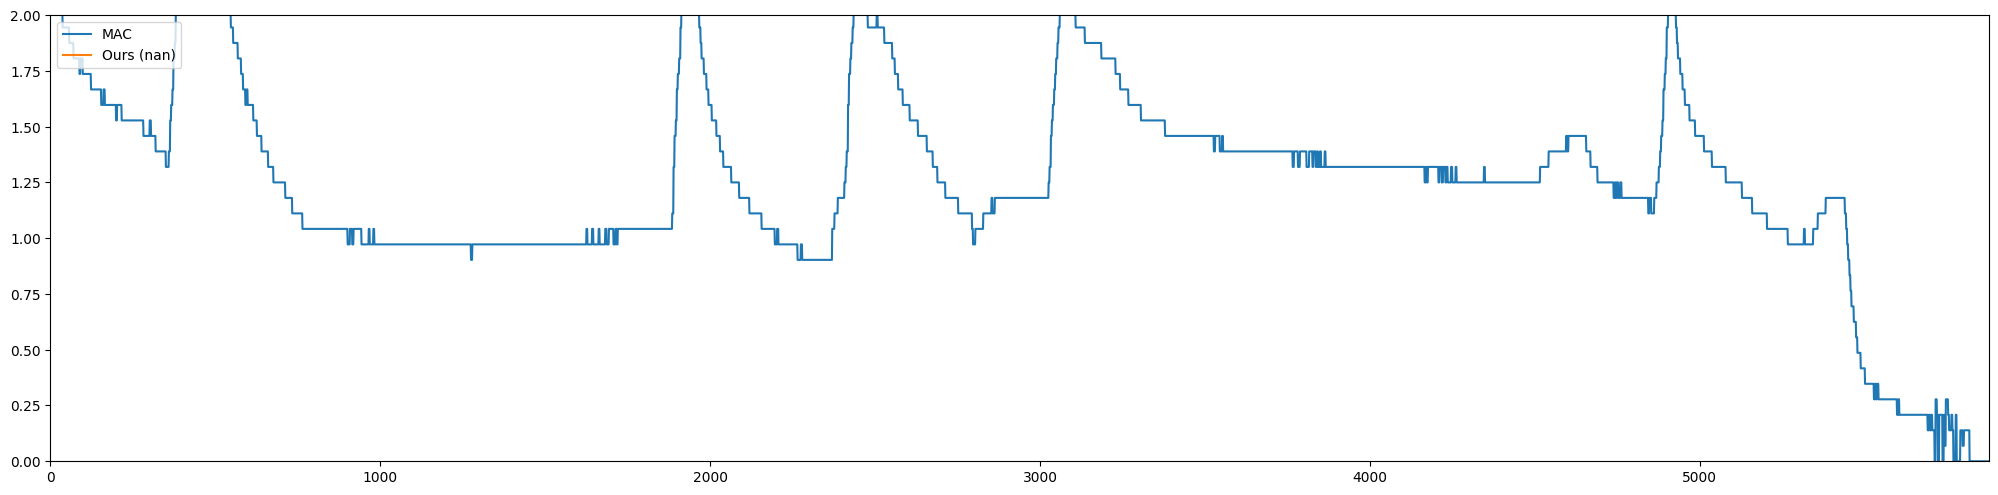

Total MAE=nan, CaseID 65, MAE=nan


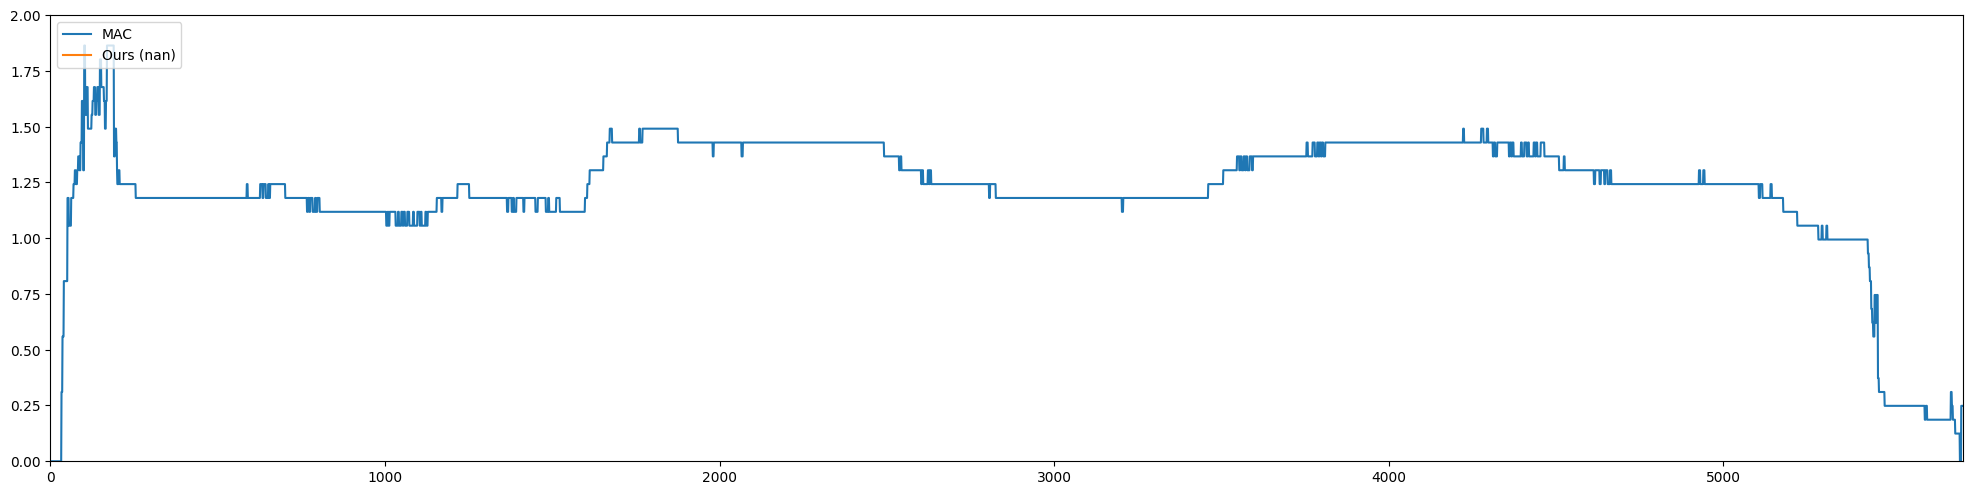

Total MAE=nan, CaseID 66, MAE=nan


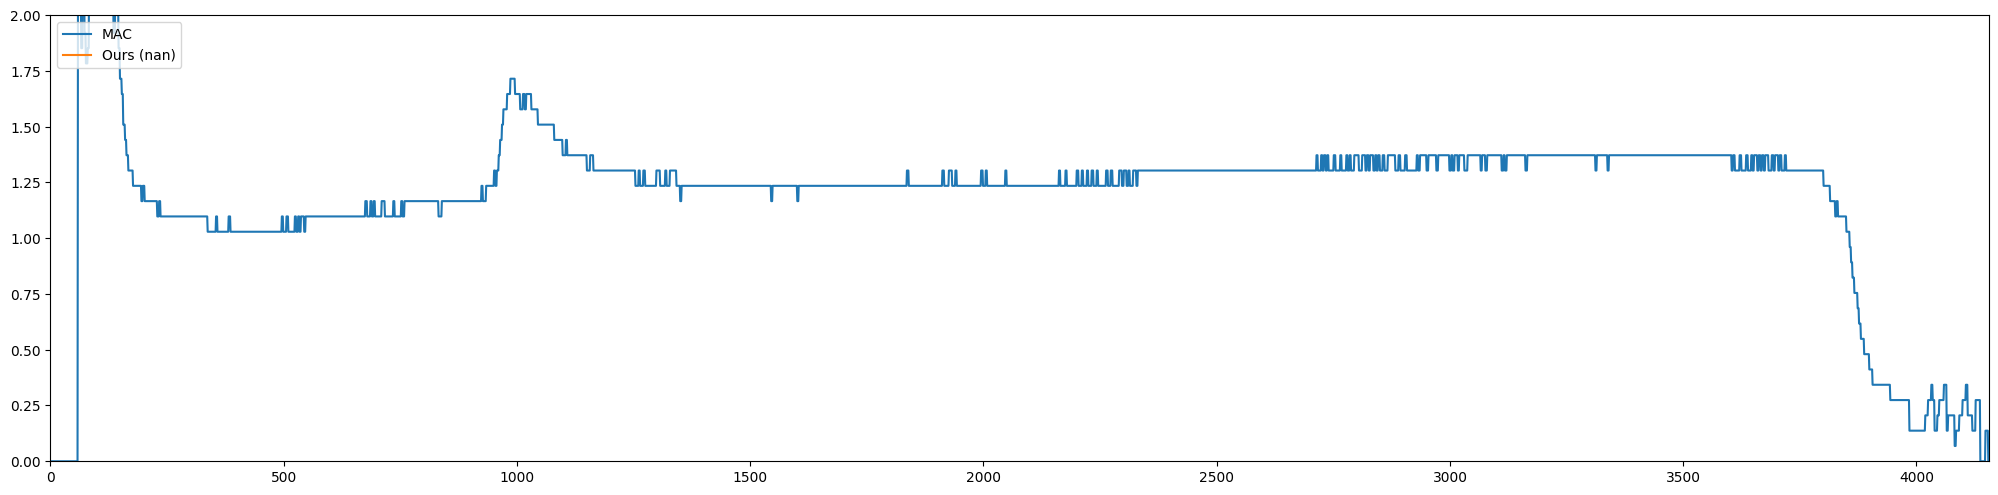

Total MAE=nan, CaseID 76, MAE=nan


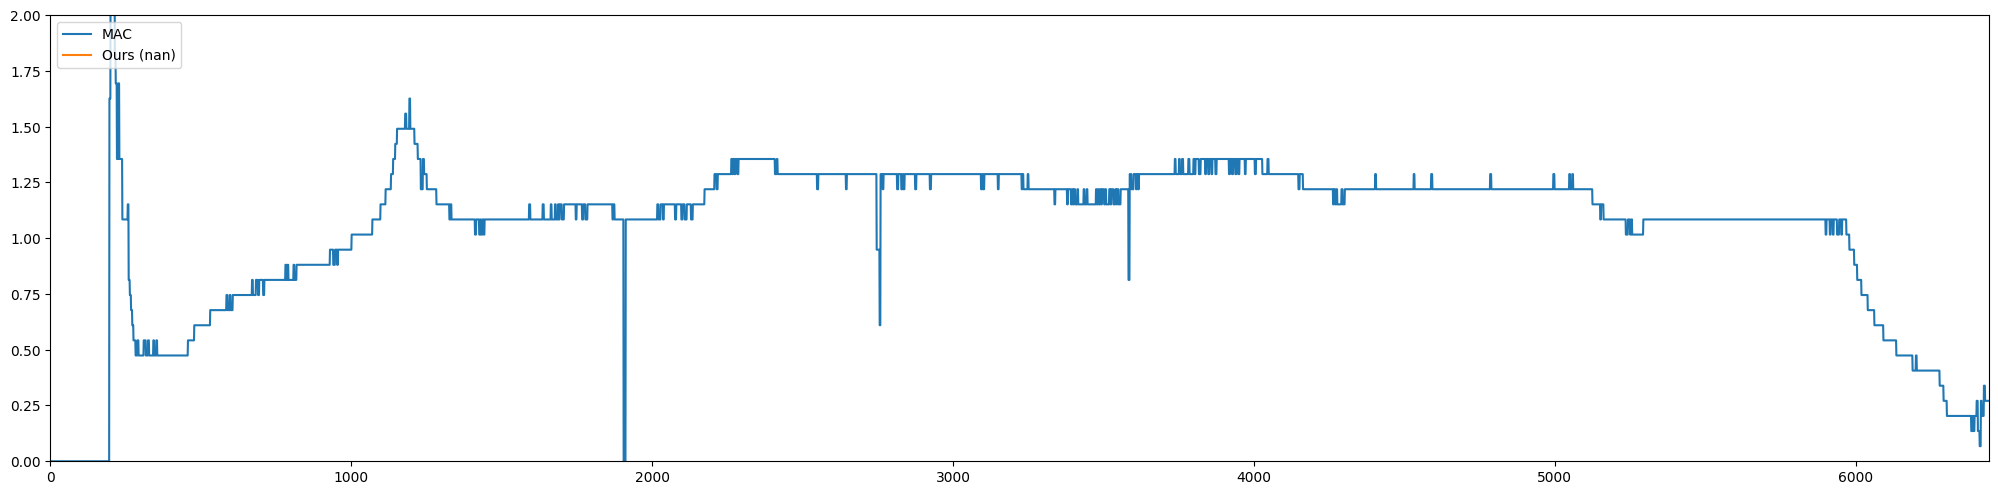

Total MAE=nan, CaseID 80, MAE=nan


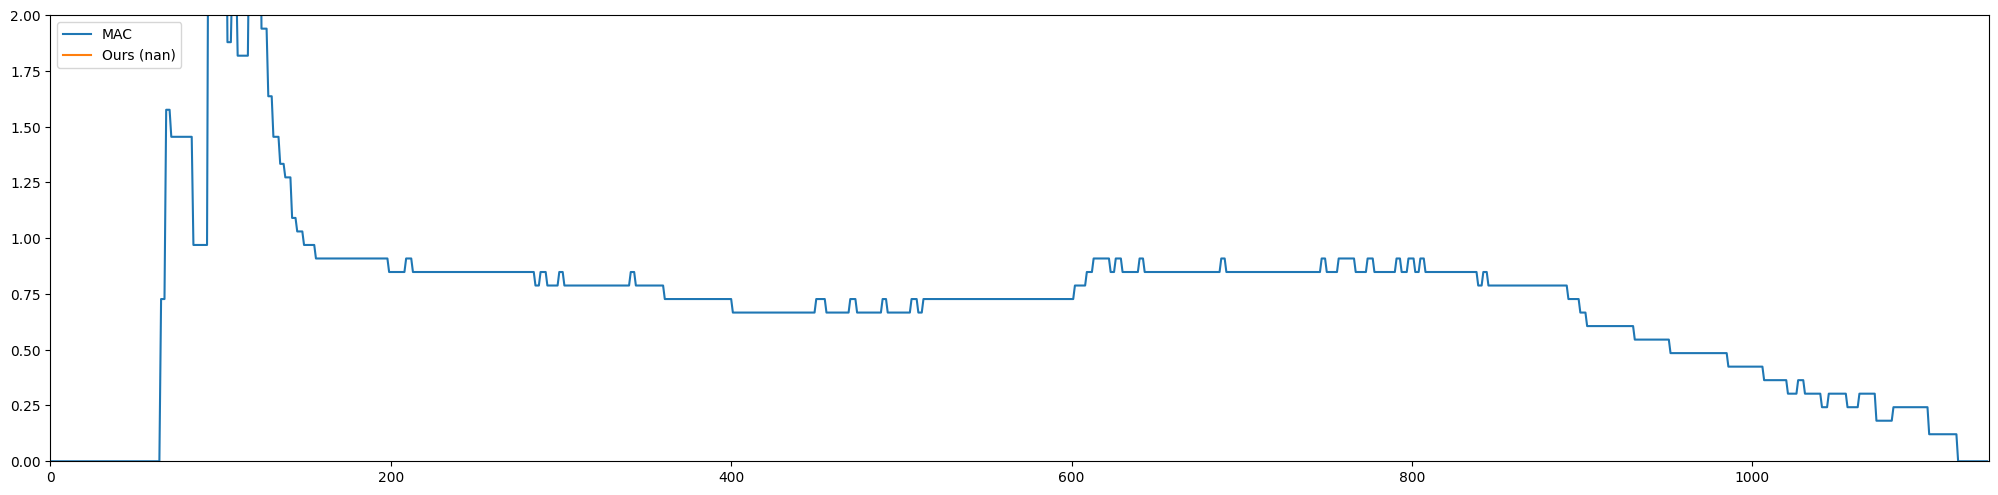

Total MAE=nan, CaseID 82, MAE=nan


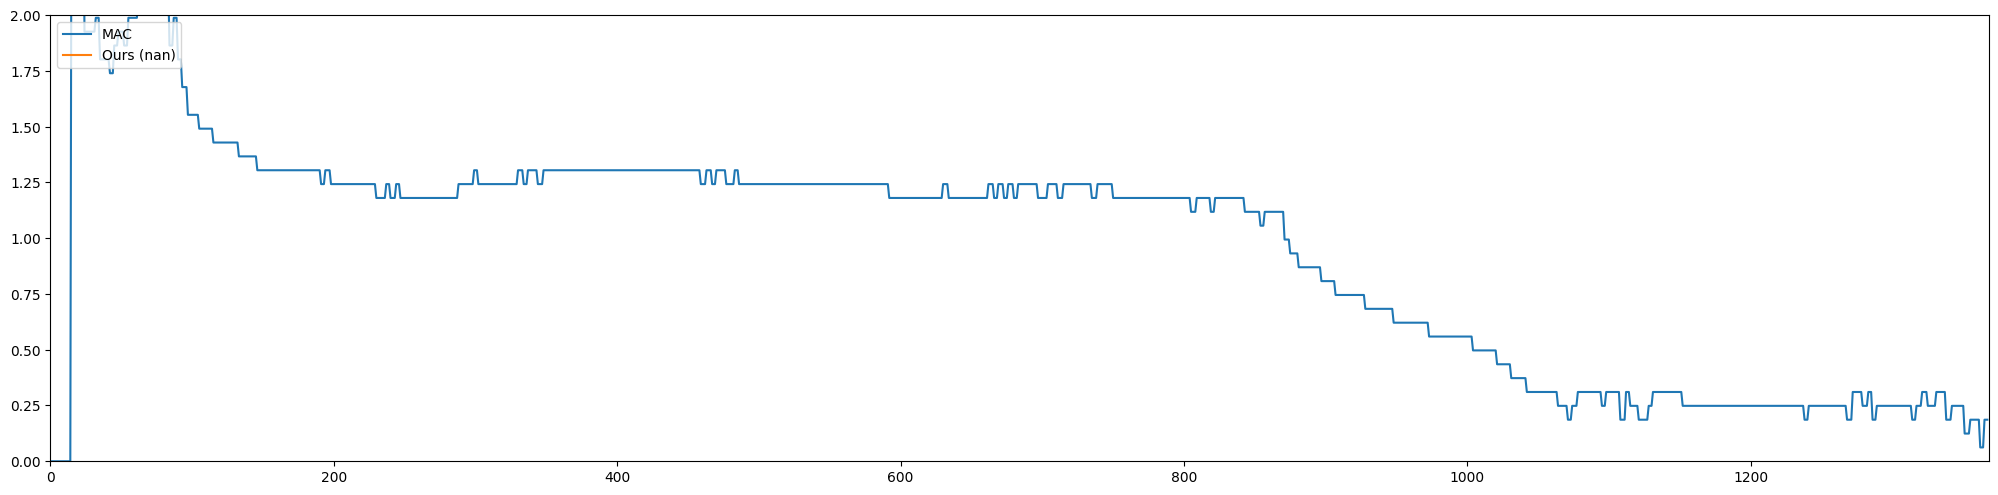

In [7]:
# plot for each case
for caseid in np.unique(c_test):
    case_mask = (c_test == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    our_mae = np.mean(np.abs(y_test[case_mask] - pred_test[case_mask]))
    print(f'Total MAE={test_mae:.4f}, CaseID {caseid}, MAE={our_mae:.4f}')

    t = np.arange(0, case_len)
    plt.figure(figsize=(20, 5))
    plt.plot(t, y_test[case_mask], label='MAC')
    plt.plot(t, pred_test[case_mask], label=f'Ours ({our_mae:.4f})')
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.xlim([0, case_len])
    plt.ylim([0, 2])
    plt.show()